<a href="https://colab.research.google.com/github/rmorlowski/Artificial-Intelligence-Deep-Learning/blob/master/Dream_Composer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Dream Composer

Deep learning / A.I. model that turns trained midi data into original compositions.

*Deep RNN with LSTM*

The purpose of this assignment is to create “bots” to explore electronic music generation. This will be accomplished by comparing recurrent neural networks (RNN) with long-short-term memory (LSTM) and different inputs. A paired comparison test will be used to see if the model is capable of producing genre-specific music. The initial results prove promising for future research applying RNN with LSTM to music creation with both models generating pleasant sequences.


---



Relevant documentation includes:
*   [F. Chollet - Deep Learning with Python](https://github.com/fchollet/deep-learning-with-python-notebooks/blob/master/8.1-text-generation-with-lstm.ipynb)
*   [M. Cuthbert - M.I.T. Music21: A toolkit for computer-aided musicology.](http://web.mit.edu/music21/)
*   [S. Skúli - How to Generate Music using a LSTM Neural Network in Keras](https://towardsdatascience.com/how-to-generate-music-using-a-lstm-neural-network-in-keras-68786834d4c5)

Import packages

In [0]:
""" This module prepares midi file data and feeds it to the neural
    network for training """
import glob
import pickle
import numpy
import time
import music21
from music21 import converter, instrument, note, chord
from keras.models import Sequential, load_model
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import LSTM
from keras.layers import Activation
from keras.optimizers import SGD
from keras.utils import np_utils
from keras.callbacks import ModelCheckpoint

In [0]:
%matplotlib inline     
# imports the matplot library to plot graphs etc.
# re-definition of sho()-method ---> "HACK" from https://github.com/psychemedia/showntell/blob/music/index_music.ipynb
# see also this music21 issue: https://github.com/cuthbertLab/music21/issues/260
%load_ext music21.ipython21

from IPython.display import Image

The music21.ipython21 extension is already loaded. To reload it, use:
  %reload_ext music21.ipython21


Setup ngrok and run TensorBoard on Colab

In [0]:
!wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
!unzip ngrok-stable-linux-amd64.zip

--2019-06-09 21:57:32--  https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
Resolving bin.equinox.io (bin.equinox.io)... 35.173.3.255, 34.231.75.48, 3.214.163.243, ...
Connecting to bin.equinox.io (bin.equinox.io)|35.173.3.255|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 16648024 (16M) [application/octet-stream]
Saving to: ‘ngrok-stable-linux-amd64.zip.2’

ngrok-stable-linux- 100%[===================>]  15.88M  36.2MB/s    in 0.4s    

2019-06-09 21:57:33 (36.2 MB/s) - ‘ngrok-stable-linux-amd64.zip.2’ saved [16648024/16648024]

Archive:  ngrok-stable-linux-amd64.zip
replace ngrok? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: ngrok                   


In [0]:
LOG_DIR = './log'
get_ipython().system_raw(
    'tensorboard --logdir {} --host 0.0.0.0 --port 6006 &'
    .format(LOG_DIR)
)

In [0]:
get_ipython().system_raw('./ngrok http 6006 &')

#### Ingest Data

**Mount zip folder to your Google Drive.**

Add the folders with the midi data files to your Google 'My Drive' in a folder labeled 'midi_data'.

In [0]:
# Mount G Drive
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


Enter your authorization code:

---


The problem is to develop two music generators, distinct in terms of the artist style or genre of music composition. “Electronic” music will represent genre A and “psychedelic rock” will represent genre B, and the resulting music generators will be Bot A and Bot B. The experimental design was created by training Bot A with transcribed songs by the artist “Odesza” to build an electronic music generator with these data. Next, Bot B was trained with transcribed songs by the artist “Tame Impala” to build a psychedelic rock music generator. 


---

**NOTE:** Load the midi contents of the "BotA" or "BotB" folder to your gdrive in a folder labeled **midi_files** or load midi data to experiment on your own:

**Midi Data**

Sort artists and songs alphabetically.

In [0]:
import os;
for filename in sorted(os.listdir("/content/gdrive/My Drive/midi_files")):
        print (filename)

Hayden_James_-_Something_About_You_ODESZA_Remix.mid
Jai_Wolf_-_Indian_Summer.mid
ODESZA_-_A_Moment_Apart.mid
ODESZA_-_Boy.mid
ODESZA_-_Falls_ft_Sasha_Sloan.mid
ODESZA_-_Higher_Ground_ft_Naomi_Wild.mid
ODESZA_-_IPlayYouListen.mid
ODESZA_-_It_s_Only_ft_Zyra.mid
ODESZA_-_Late_Night.mid
ODESZA_-_Line_of_Sight_ft_Wynne_Mansionair.mid
ODESZA_-_Memories_That_You_Call.mid
ODESZA_-_Say_My_Name_ft_Zyra.mid
Porter_Robinson_-_Divinity_ODESZA_Remix.mid
RUFUS_-_You_Were_Right.mid


In [0]:
# get the data
cd '/content/gdrive/My Drive/'

/content/gdrive/My Drive


In [0]:
pwd

'/content/gdrive/My Drive'

### EDA

In [0]:
# Count number of midi files in directory
os.path

# path joining version for other paths, location of midi files
DIR = '/content/gdrive/My Drive/midi_files'
print (len([name for name in os.listdir(DIR) if os.path.isfile(os.path.join(DIR, name))]))

14


**Visualize data with music21**

Let's choose a song from the directory listed above for further analysis.

In [0]:
#try data visualization with music21
#https://web.mit.edu/music21/doc/about/what.html

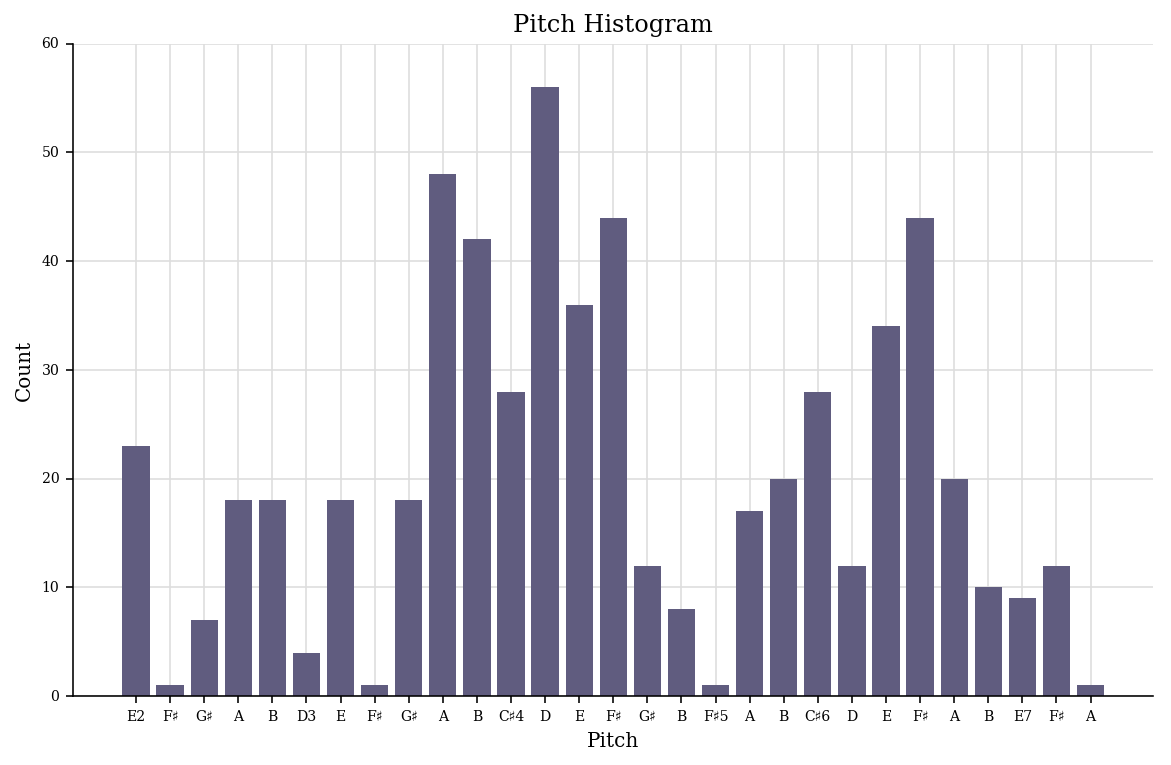

In [0]:
# Get a quick graph showing how common various pitches are in a a modern electronic piece:
p = converter.parse('/content/gdrive/My Drive/midi_files/ODESZA_-_IPlayYouListen.mid')
p.plot('histogram', 'pitch')

In [0]:
# Let's look at the musical notation for this piece:

In [0]:
# What is the key of this song?
p.analyze('key')

<music21.key.Key of A major>

Below we have another excerpt from a midi file that has been read using Music21, only this time we have added the offset of the object behind it. This allows us to see the interval between each note and chord.

In [0]:
# What does this song look like when translated to notes and chords?
p.show('text')

{0.0} <music21.stream.Part 0x7fd0137f9588>
    {0.0} <music21.instrument.Piano Piano>
    {0.0} <music21.tempo.MetronomeMark animato Quarter=120.0>
    {0.0} <music21.meter.TimeSignature 4/4>
    {0.0} <music21.stream.Voice 0x7fd013585f60>
        {0.0} <music21.note.Rest rest>
        {0.25} <music21.note.Note F#>
        {2.0} <music21.note.Note A>
        {3.3333} <music21.note.Note F#>
        {4.25} <music21.note.Note B>
        {5.25} <music21.note.Note A>
        {6.25} <music21.note.Note F#>
        {6.6667} <music21.note.Note E>
        {7.0} <music21.note.Note D>
        {7.5} <music21.note.Note E>
        {8.5} <music21.note.Note A>
        {9.3333} <music21.note.Note F#>
        {10.75} <music21.note.Note E>
        {10.75} <music21.chord.Chord E6 E7>
        {11.6667} <music21.note.Note A>
        {12.6667} <music21.note.Note F#>
        {13.5} <music21.note.Note E>
        {14.0} <music21.note.Note D>
        {14.75} <music21.note.Note C#>
        {15.75} <music21.note.No

The data splits into two object types: Notes and Chords. Note objects contain information about the pitch, octave, and offset of the Note.

In [0]:
# How many parts are there to this song?
# Note: it should be = 1 if the .midi is a piano instrument
len(p.parts)

1

In [0]:
# How many notes are in this song?
len(p.flat.notes)

467

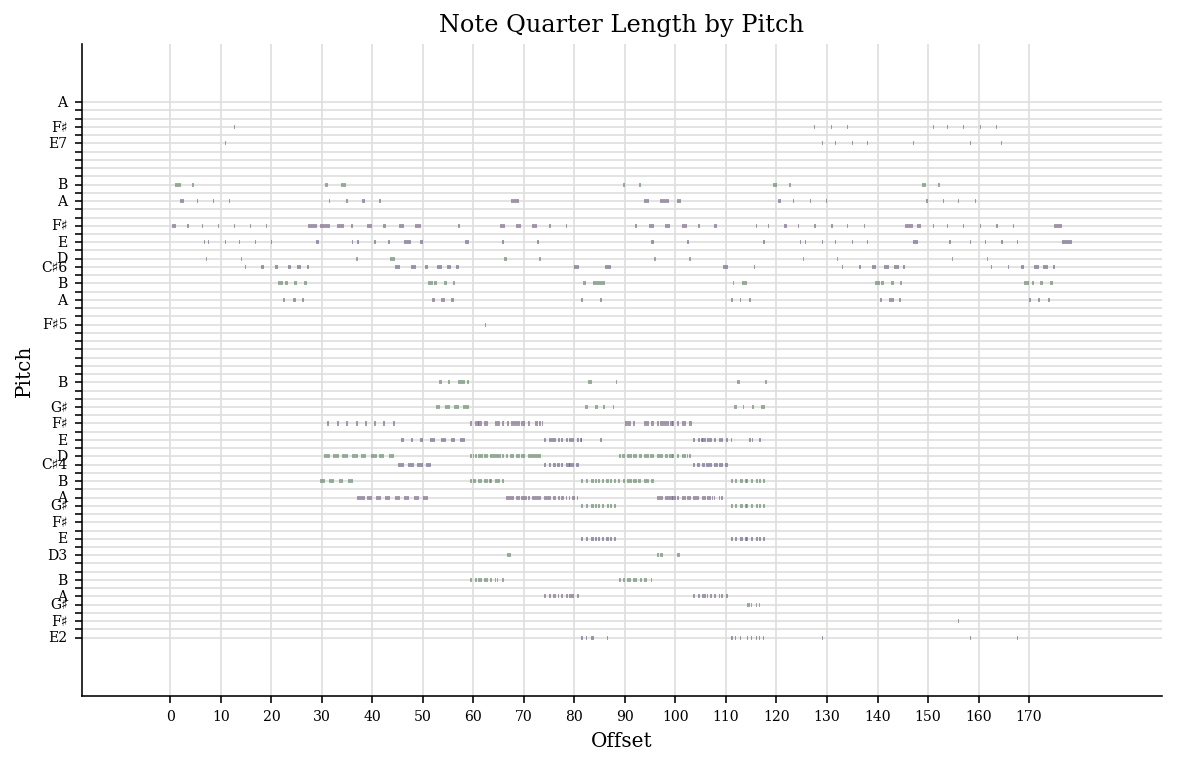

In [0]:
# Plot the piano roll:
p.plot('pianoroll')

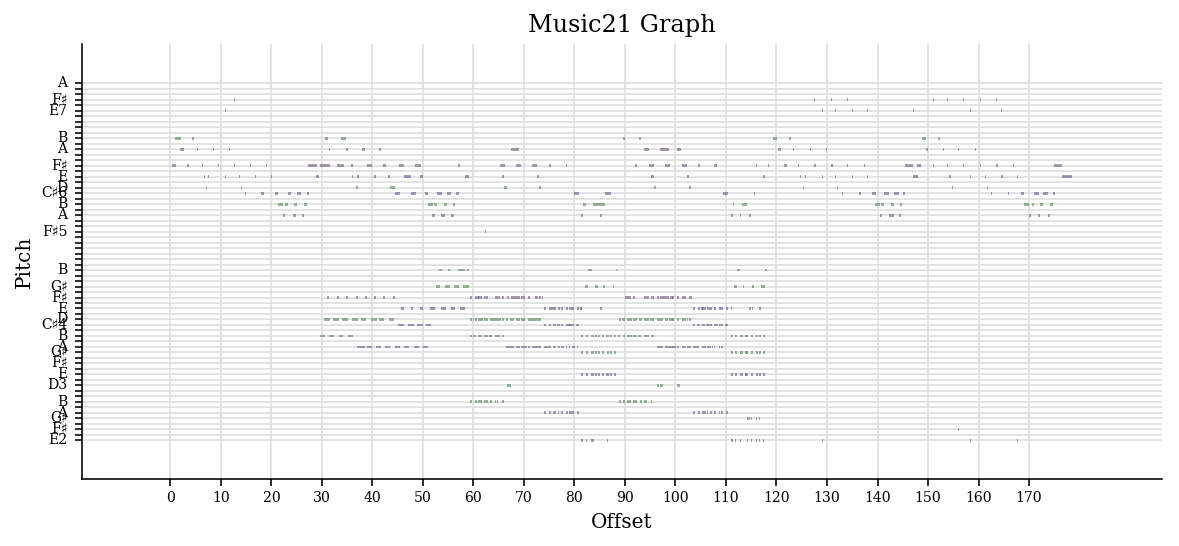

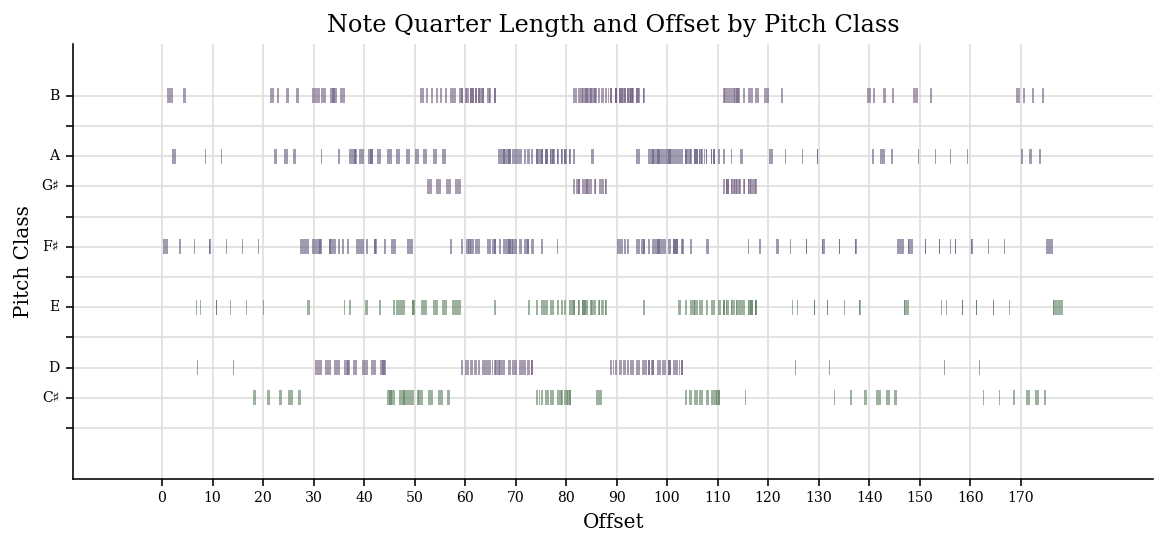

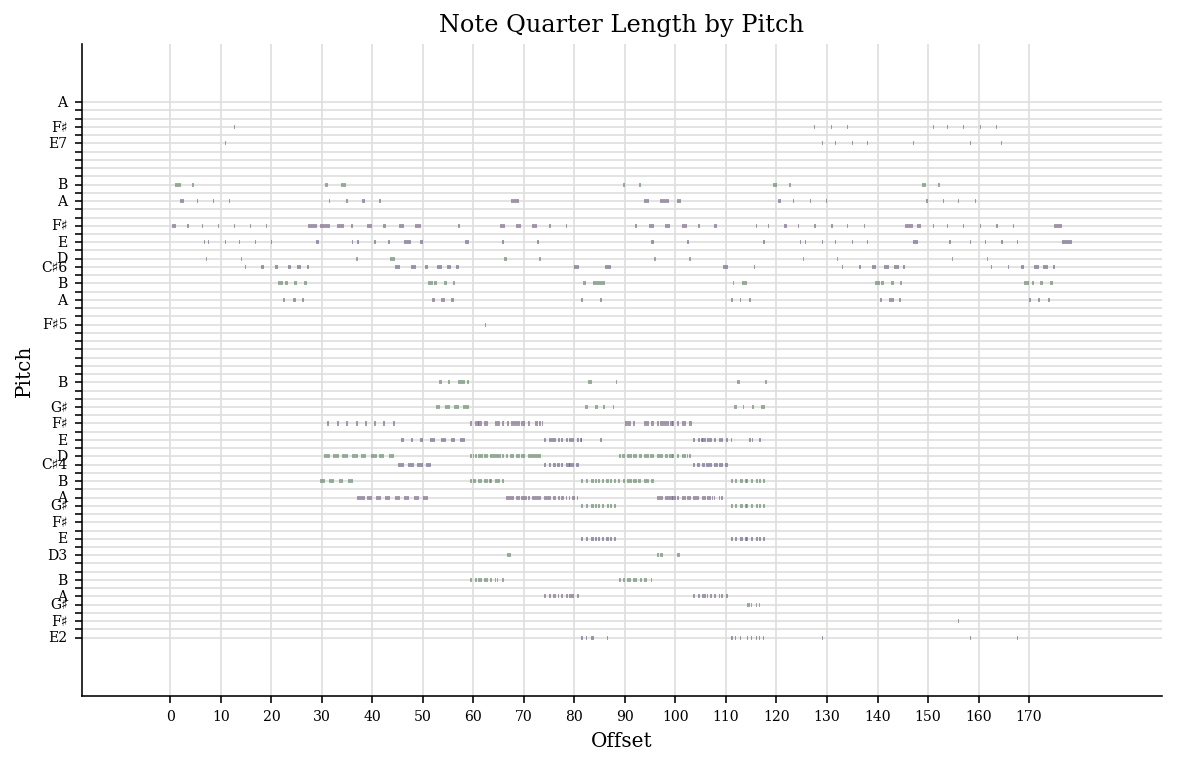

In [0]:
# Plot a horizontal bar chart loking at pitch and offset in more detail:
p.plot('horizontalbar')

### Train the Model

First, we will load the data into an array as can be seen in the code snippet below:

In [0]:
def train_network():
    """ Train a Neural Network to generate music """
    notes = get_notes()

    # get amount of pitch names
    n_vocab = len(set(notes))

    network_input, network_output = prepare_sequences(notes, n_vocab)

    model = create_network(network_input, n_vocab)

    train(model, network_input, network_output)

Start by loading each file into a Music21 stream object using the converter.parse(file) function. Using that stream object we get a list of all the notes and chords in the file.

Load data from working directory with midi songs.

In [0]:
def get_notes():
    """ Get all the notes and chords from the midi files in the ./midi_songs directory """
    notes = []

    for file in glob.glob("/content/gdrive/My Drive/midi_files/*.mid"):
        midi = converter.parse(file)

        print("Parsing %s" % file)

        notes_to_parse = None

        try: # file has instrument parts
            s2 = instrument.partitionByInstrument(midi)
            notes_to_parse = s2.parts[0].recurse() 
        except: # file has notes in a flat structure
            notes_to_parse = midi.flat.notes

        for element in notes_to_parse:
            if isinstance(element, note.Note):
                notes.append(str(element.pitch))
            elif isinstance(element, chord.Chord):
                notes.append('.'.join(str(n) for n in element.normalOrder))

    with open('data/notes', 'wb') as filepath:
        pickle.dump(notes, filepath)

    return notes

Now that we have put all the notes and chords into a sequential list we can create the sequences that will serve as the input of our network.

Next, we have to create input sequences for the network and their respective outputs. The output for each input sequence will be the first note or chord that comes after the sequence of notes in the input sequence in our list of notes.

The final step in preparing the data for the network is to normalise the input and one-hot encode the output.

In [0]:
def prepare_sequences(notes, n_vocab):
    """ Prepare the sequences used by the Neural Network """
    sequence_length = 25

    # get all pitch names
    pitchnames = sorted(set(item for item in notes))

     # create a dictionary to map pitches to integers
    note_to_int = dict((note, number) for number, note in enumerate(pitchnames))

    network_input = []
    network_output = []

    # create input sequences and the corresponding outputs
    for i in range(0, len(notes) - sequence_length, 1):
        sequence_in = notes[i:i + sequence_length]
        sequence_out = notes[i + sequence_length]
        network_input.append([note_to_int[char] for char in sequence_in])
        network_output.append(note_to_int[sequence_out])

    n_patterns = len(network_input)

    # reshape the input into a format compatible with LSTM layers
    network_input = numpy.reshape(network_input, (n_patterns, sequence_length, 1))
    # normalize input
    network_input = network_input / float(n_vocab)

    network_output = np_utils.to_categorical(network_output)

    return (network_input, network_output)

In [0]:
# define hyperparameters:
# Time-Based Learning Rate Schedule
epochs = 200
#learning_rate = 0.1
#decay_rate = learning_rate / epochs
#momentum = 0.8
#sgd = SGD(lr=learning_rate, momentum=momentum, decay=decay_rate, nesterov=False)

### Keras Model

Finally we get to designing the model architecture.

In [0]:
def create_network(network_input, n_vocab):
    """ create the structure of the neural network """
    model = Sequential()
    model.add(LSTM(
        512,
        input_shape=(network_input.shape[1], network_input.shape[2]),
        return_sequences=True
    ))
    model.add(Dropout(0.2))
    model.add(LSTM(512, return_sequences=True))
    model.add(Dropout(0.3))
    model.add(LSTM(512))
    model.add(Dense(256))
    model.add(Dropout(0.4))
    model.add(Dense(n_vocab))
    model.add(Activation('softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='rmsprop')

    return model

**NOTE:** You can stop the process at any point in time and the weights from the latest completed epoch will be available for sequence generation purposes.

In [0]:
from keras.callbacks import TensorBoard

To calculate the loss for each iteration of the training we will be using categorical cross entropy since each of our outputs only belongs to a single class and we have more than two classes to work with. And to optimise our network we will use a RMSprop optimizer as it is usually a very good choice for recurrent neural networks.

In [0]:
%%time
def train(model, network_input, network_output):
    """ train the neural network """
    filepath = "Real.hdf5"
    checkpoint = ModelCheckpoint(
        filepath,
        monitor='loss',
        verbose=0,
        save_best_only=True,
        mode='min'
    )
    tbCallBack = TensorBoard(log_dir='./log',
                         write_graph=True,
                         write_grads=True,
                         write_images=True)
    callbacks_list = [checkpoint, tbCallBack]
    
    #model = load_model('Real.hdf5')
    model.fit(network_input, network_output, epochs=epochs, batch_size=32, callbacks=callbacks_list)
    model.save('Real.hdf5')

if __name__ == '__main__':
    train_network()

Parsing /content/gdrive/My Drive/midi_files/Porter_Robinson_-_Divinity_ODESZA_Remix.mid
Parsing /content/gdrive/My Drive/midi_files/ODESZA_-_Say_My_Name_ft_Zyra.mid
Parsing /content/gdrive/My Drive/midi_files/ODESZA_-_Memories_That_You_Call.mid
Parsing /content/gdrive/My Drive/midi_files/ODESZA_-_Line_of_Sight_ft_Wynne_Mansionair.mid
Parsing /content/gdrive/My Drive/midi_files/ODESZA_-_Late_Night.mid
Parsing /content/gdrive/My Drive/midi_files/ODESZA_-_It_s_Only_ft_Zyra.mid
Parsing /content/gdrive/My Drive/midi_files/ODESZA_-_Boy.mid
Parsing /content/gdrive/My Drive/midi_files/ODESZA_-_Higher_Ground_ft_Naomi_Wild.mid
Parsing /content/gdrive/My Drive/midi_files/ODESZA_-_IPlayYouListen.mid
Parsing /content/gdrive/My Drive/midi_files/ODESZA_-_A_Moment_Apart.mid
Parsing /content/gdrive/My Drive/midi_files/ODESZA_-_Falls_ft_Sasha_Sloan.mid
Parsing /content/gdrive/My Drive/midi_files/Hayden_James_-_Something_About_You_ODESZA_Remix.mid
Parsing /content/gdrive/My Drive/midi_files/RUFUS_-_You_W

#### Review Results in **TensorBoard**

In [0]:
! curl -s http://localhost:4040/api/tunnels | python3 -c \
    "import sys, json; print(json.load(sys.stdin)['tunnels'][0]['public_url'])"

### Generate Music

Now that we have finished training the network it is time to have some fun with the network we have spent hours training.

In [0]:
""" This module generates notes for a midi file using the
    trained neural network """
import pickle
import numpy
from music21 import instrument, note, stream, chord
from keras.models import Sequential, load_model
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import LSTM
from keras.layers import Activation

In [0]:
def generate():
    """ Generate a piano midi file """
    #load the notes used to train the model
    with open('data/notes', 'rb') as filepath:
        notes = pickle.load(filepath)

    # Get all pitch names
    pitchnames = sorted(set(item for item in notes))
    # Get all pitch names
    n_vocab = len(set(notes))

    network_input, normalized_input = prepare_sequences(notes, pitchnames, n_vocab)
    model = create_network(normalized_input, n_vocab)
    prediction_output = generate_notes(model, network_input, pitchnames, n_vocab)
    create_midi(prediction_output)

In [0]:
def prepare_sequences(notes, pitchnames, n_vocab):
    """ Prepare the sequences used by the Neural Network """
    # map between notes and integers and back
    note_to_int = dict((note, number) for number, note in enumerate(pitchnames))

    sequence_length = 25
    network_input = []
    output = []
    for i in range(0, len(notes) - sequence_length, 1):
        sequence_in = notes[i:i + sequence_length]
        sequence_out = notes[i + sequence_length]
        network_input.append([note_to_int[char] for char in sequence_in])
        output.append(note_to_int[sequence_out])

    n_patterns = len(network_input)

    # reshape the input into a format compatible with LSTM layers
    normalized_input = numpy.reshape(network_input, (n_patterns, sequence_length, 1))
    # normalize input
    normalized_input = normalized_input / float(n_vocab)

    return (network_input, normalized_input)

To be able to use the neural network to generate music you will have to put it into the same state as before. For simplicity we will reuse code from the training section to prepare the data and set up the network model in the same way as before. Except, that instead of training the network we load the weights that we saved during the training section into the model.

In [0]:
def create_network(network_input, n_vocab):
    """ create the structure of the neural network """
    model = Sequential()
    model.add(LSTM(
        512,
        input_shape=(network_input.shape[1], network_input.shape[2]),
        return_sequences=True
    ))
    model.add(Dropout(0.2))
    model.add(LSTM(512, return_sequences=True))
    model.add(Dropout(0.3))
    model.add(LSTM(512))
    model.add(Dense(256))
    model.add(Dropout(0.4))
    model.add(Dense(n_vocab))
    model.add(Activation('softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='rmsprop')

    # Load the weights to each node
    model.load_weights('Real.hdf5')

    return model

Since we have a full list of note sequences at our disposal we will pick a random index in the list as our starting point, this allows us to rerun the generation code without changing anything and get different results every time.

In [0]:
def generate_notes(model, network_input, pitchnames, n_vocab):
    """ Generate notes from the neural network based on a sequence of notes """
    # pick a random sequence from the input as a starting point for the prediction
    start = numpy.random.randint(0, len(network_input)-1)

    int_to_note = dict((number, note) for number, note in enumerate(pitchnames))

    pattern = network_input[start]
    prediction_output = []

    # generate 500 notes
    for note_index in range(500):
        prediction_input = numpy.reshape(pattern, (1, len(pattern), 1))
        prediction_input = prediction_input / float(n_vocab)

        prediction = model.predict(prediction_input, verbose=0)

        index = numpy.argmax(prediction)
        result = int_to_note[index]
        prediction_output.append(result)

        pattern.append(index)
        pattern = pattern[1:len(pattern)]

    return prediction_output


Now that we have all the encoded representations of the notes and chords in an array we can start decoding them and creating an array of Note and Chord objects.

At the end of each iteration we increase the offset by 0.5 and append the Note/Chord object created to a list.

In [0]:
def create_midi(prediction_output):
    """ convert the output from the prediction to notes and create a midi file
        from the notes """
    offset = 0
    output_notes = []

    # create note and chord objects based on the values generated by the model
    for pattern in prediction_output:
        # pattern is a chord
        if ('.' in pattern) or pattern.isdigit():
            notes_in_chord = pattern.split('.')
            notes = []
            for current_note in notes_in_chord:
                new_note = note.Note(int(current_note))
                new_note.storedInstrument = instrument.Piano()
                notes.append(new_note)
            new_chord = chord.Chord(notes)
            new_chord.offset = offset
            output_notes.append(new_chord)
        # pattern is a note
        else:
            new_note = note.Note(pattern)
            new_note.offset = offset
            new_note.storedInstrument = instrument.Piano()
            output_notes.append(new_note)

        # increase offset each iteration so that notes do not stack
        offset += 0.5

    midi_stream = stream.Stream(output_notes)

    midi_stream.write('midi', fp='test_output.mid')

if __name__ == '__main__':
    generate()

**Good luck!  Cross your fingers the model runs in a reasonable amount of time.**

### Conclusion

After fitting both neural networks, processing time and performance was compared across experimental treatments. The performance loss varied significantly between each run depending on where the random sequence started from using the input for the prediction.


>>>> **Summary Table:**



>Model | Genre |Corpus Length | Number of Epochs | Processing Time | Loss
>--- | --- | --- | --- | --- | ---
>Bot A | Electronic | 20055| 200| 4hr 21min | 0.2428
>Bot B |Psych-Rock | 11000 | 200| 2hr 35min | 0.1244

Training an RNN LSTM model with new midi data is extremely computationally expensive and only accurate for short sequences. The majority of the artificial intelligence music creation algorithms available online use pre-trained models. The RNN LSTM models successfully processed these sequences over time but were relatively expensive and varied in accuracy. The final takeaway for a musician that would like to augment artificial intelligence into their workflow is creating genre-specific music is possible, with the caveat that it may only produce short cohesive sequences.

**Management problem:** 

In summary, developing a bot to generate genre-specific musical sequences is a challenging undertaking. The network architecture is a key element in building a neural network model for music generation especially selection of the types of layers. It would be interesting to introduce temperature or see if an attention layer is more appropriate for sequenced music generation but that topic remains for future study. The final recommendation is to experiment with the RNN LSTM model for music generation, you never know what new surprises you will find.